In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c instacart-market-basket-analysis

 92% 180M/196M [00:01<00:00, 160MB/s]
100% 196M/196M [00:01<00:00, 127MB/s]


In [ ]:
!unzip -q instacart-market-basket-analysis.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#garbage collector
import gc
gc.enable() #enabling collection

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
print("Unzipping ...")
!unzip  'aisles.csv.zip'
!unzip  'departments.csv.zip'
!unzip  'order_products__prior.csv.zip'
!unzip  'order_products__train.csv.zip'
!unzip  'orders.csv.zip'
!unzip  'products.csv.zip'
!unzip  'sample_submission.csv.zip'
print(". done")

Unzipping ...
Archive:  aisles.csv.zip
  inflating: aisles.csv              
   creating: __MACOSX/
  inflating: __MACOSX/._aisles.csv   
Archive:  departments.csv.zip
  inflating: departments.csv         
  inflating: __MACOSX/._departments.csv  
Archive:  order_products__prior.csv.zip
  inflating: order_products__prior.csv  
  inflating: __MACOSX/._order_products__prior.csv  
Archive:  order_products__train.csv.zip
  inflating: order_products__train.csv  
  inflating: __MACOSX/._order_products__train.csv  
Archive:  orders.csv.zip
  inflating: orders.csv              
  inflating: __MACOSX/._orders.csv   
Archive:  products.csv.zip
  inflating: products.csv            
  inflating: __MACOSX/._products.csv  
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
. done


In [ ]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv('departments.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [ ]:
print(products.shape[0])
products.head()

49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
# Check row counts
print("aisles:", aisles.shape[0])
print("departments:", departments.shape[0])
print("order_products__prior:", order_products__prior.shape[0])
print("order_products__train:", order_products__train.shape[0])
print("orders:", orders.shape[0])
print("products:", products.shape[0])

aisles: 134
departments: 21
order_products__prior: 32434489
order_products__train: 1384617
orders: 3421083
products: 49688


In [ ]:
# Take the first 1000000 rows
# orders_subset = orders.head(1000000)
orders_subset = orders[orders.user_id <= 10000].dropna().reset_index()

In [ ]:
order_products__prior_filtered = order_products__prior['product_id'].value_counts().reset_index()
order_products__prior_filtered.columns = ['product_id', 'count']
order_products__prior_filtered = order_products__prior_filtered[order_products__prior_filtered['count'] >= order_products__prior['product_id'].value_counts().quantile(0.9)]
order_products__prior_filtered

,product_id,count
0,24852,472565
1,13176,379450
2,21137,264683
3,21903,241921
4,47209,213584


In [ ]:
#concat train order and prior orders
prior_train_orders = pd.concat([order_products__prior_filtered, order_products__train]).sort_values(by=['order_id'])

#merge with rest

prior_train_orders = pd.merge(left = prior_train_orders, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_train_orders = pd.merge(left = prior_train_orders, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_train_orders = pd.merge(left = prior_train_orders, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_train_orders = pd.merge(left = prior_train_orders, right = orders_subset,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)


col_order = ['user_id','order_id','product_id','aisle_id','department_id','add_to_cart_order',
 'reordered','product_name','aisle','department','eval_set','order_number','order_dow','order_hour_of_day',
 'days_since_prior_order']

prior_train_orders = prior_train_orders[col_order]
prior_train_orders

,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,112108,1.0,49302,120,16,1.0,1.0,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0
1,112108,1.0,13176,24,4,6.0,0.0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0
2,112108,1.0,47209,24,4,7.0,0.0,Organic Hass Avocado,fresh fruits,produce,train,4,4,10,9.0
3,112108,1.0,10246,83,4,3.0,0.0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0
4,112108,1.0,43633,95,15,5.0,1.0,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384612,169679,3421063.0,14233,115,7,3.0,1.0,Natural Artesian Water,water seltzer sparkling water,beverages,train,30,0,10,4.0
1384613,169679,3421063.0,13565,107,19,2.0,1.0,No Salt Added Gluten-Free Blue Chips Made with...,chips pretzels,snacks,train,30,0,10,4.0
1384614,139822,3421070.0,35951,91,16,1.0,1.0,Organic Unsweetened Almond Milk,soy lactosefree,dairy eggs,train,15,6,10,8.0
1384615,139822,3421070.0,16953,88,13,2.0,1.0,Creamy Peanut Butter,spreads,pantry,train,15,6,10,8.0


### Applying Apriori algorithm on the table directly

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# Transaction Encoding
te = TransactionEncoder()

# Data Preprocessing
transactions = prior_train_orders.groupby('user_id')['product_name'].apply(list)

te_ary = te.fit(transactions).transform(transactions, sparse=True)

# Convert the sparse matrix to a DataFrame
df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

# Apply Apriori Algorithm
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

# Generate Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display the rules
print(rules)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


In [ ]:
# # Aggregate data
# test_data = prior_train_orders.groupby(['product_id', 'product_name', 'aisle', 'department']).agg({
#     'user_id': 'count',  # Count of users who ordered the product
#     'reordered': 'sum'   # Total number of times the product was reordered
# }).reset_index()

# # Rename columns for clarity
# test_data.columns = ['product_id', 'product_name', 'aisle', 'department', 'user_count', 'reorder_count']

# # Display the result
# test_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # Aggregate data at the order and product level
# aggregated_data = prior_train_orders.groupby(['order_id', 'product_id']).agg({
#     'user_id': 'first',       # Assuming user_id is the same for all rows in an order-product combination
#     'reordered': 'sum',       # Total number of times the product was reordered in the order
#     'product_name': 'first',  # Assuming product_name is the same for all rows in an order-product combination
#     'aisle': 'first',         # Assuming aisle is the same for all rows in an order-product combination
#     'department': 'first'     # Assuming department is the same for all rows in an order-product combination
# }).reset_index()

# # Rename columns for clarity
# aggregated_data.columns = ['order_id', 'product_id', 'user_id', 'reorder_count', 'product_name', 'aisle', 'department']

# # Display the result
# aggregated_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules  # MBA
from scipy import sparse  # sparse matrices

# limiting and splitting the dataframe into four relatively equal parts for memory efficiency below
small_train = prior_train_orders[['order_id', 'product_id']]
# small_train_split = (small_train[:461539], small_train[461539:461539*2-1], small_train[461539*2-1:])
# small_train_split = (small_train[:133942], small_train[133942:133942*2-1], small_train[133942*2-1:])
small_train_split = (small_train[:22106], small_train[22106:22106*2-1], small_train[22106*2-1:])
# small_train_split = (small_train[:346154], small_train[346154:346154*2-1],
#                      small_train[346154*2:346154*3-1], small_train[346154*3:])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print("small train:", small_train['order_id'].value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The following steps are taken for preparation of data:

1. Initialization of pivots list: we initialize an empty list called pivots which will be used to store sparse matrices.

2. Loop through small_train_split:
  * The pivot function is used to reshape the DataFrame df by setting the 'order_id' column as the index, 'product_id' column as columns, and filling the values with 'product_id'.
  * The isna() function checks for missing values and returns a DataFrame of the same shape with True for missing values and False for non-missing values.
  * The ~ operator is used to invert the boolean values, so now True represents non-missing values, and False represents missing values.
  * The resulting DataFrame is then converted to a sparse matrix using astype(pd.SparseDtype(bool)).

3. Append the sparse matrix to the pivots list
4. Memory optimization: We delete the variable pvt, presumably to free up memory since the sparse matrices have been appended to the pivots list. This is a good practice to manage memory efficiently, especially if dealing with a large dataset.
5. We create a sorted list of unique product IDs from the 'product_id' column of the small_train DataFrame.

In [ ]:
pivots = []
for df in small_train_split:
    pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())
    pivots.append(pvt.astype(pd.SparseDtype(bool)))
del pvt

product_cols = sorted(small_train.product_id.unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-27-b3ad9e678f68>:3: PerformanceWarning: The following operation may generate 4937213124 cells in the resulting pandas object.
  pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())


Data Processing pipeline:

1. Loop through the pivots list: Iterating over each sparse matrix in the pivots list, we go for reindexing and standardizing columns in use.
  * `reindex` is used to standardize the columns of the sparse matrix to match the order specified in `product_cols`.
  * columns=`product_cols` ensures that the columns are ordered according to `product_cols`.
  * `fill_value`=`False` is used to fill any missing columns with `False`.
  * `astype(pd.SparseDtype(bool))` ensures that the resulting DataFrame is converted back to a sparse matrix, specifically a boolean sparse matrix.

2. Convert to Compressed Sparse Row (CSR) Matrix:
  * After reindexing and ensuring a sparse boolean format, the code converts the DataFrame back to a compressed sparse row (CSR) matrix using sparse.csr_matrix. CSR is a common sparse matrix format that is memory-efficient for arithmetic operations.

3. Concatenate Vertically (Stacking): Finally, the code vertically stacks (concatenates) all the sparse matrices in the pivots list using sparse.vstack. This results in a single sparse matrix where the rows are combined from each original sparse matrix in pivots.

In [ ]:
for i in range(len(pivots)):
    # reindexing to add extra columns and standardize the format for vstack
    # we sparse them again here b/c otherwise we would end up having regular boolean columns
    pivots[i] = pivots[i].reindex(columns=product_cols, fill_value=False).astype(pd.SparseDtype(bool))
    pivots[i] = sparse.csr_matrix(pivots[i])
# concat vertically
pivots = sparse.vstack(pivots)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# from scipy.sparse import vstack

# # Assuming you have a sparse matrix named 'pivots'
# pivots = vstack(pivots)

# # Assuming you have a sparse matrix named 'pivots'
# dense_matrix = pivots.todense()

# # Count all values (both non-zero and zero)
# total_values = dense_matrix.size

# # Print the result
# print("Total number of values in the dense representation of pivots:", total_values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This line of code creates a truth table DataFrame where each row represents a unique order, each column represents a unique product, and the entries in the DataFrame indicate whether a particular product is associated with a specific order (based on the information stored in the original sparse matrix pivots).

In [ ]:
# # re-map and densify for algos
# dense_matrix = pivots.todense()

# # Assuming you have a DataFrame named 'small_train'
# unique_order_ids = small_train['order_id'].unique()[:dense_matrix.shape[0]]

# Create the DataFrame with the correct number of unique order IDs
# truth_table = pd.DataFrame(dense_matrix, index=unique_order_ids, columns=product_cols)

truth_table = pd.DataFrame(pivots.todense()[:-2, :], index=small_train.order_id.unique(), columns=product_cols)
# truth_table = pd.DataFrame(pivots.todense(), index=small_train.order_id.unique(), columns=product_cols)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In summary, this code concatenates the sparse matrices in pivots vertically to create a single sparse matrix (concatenated_pivots). It then densifies this matrix and creates a DataFrame (truth_table) where each row represents a unique order, each column represents a unique product, and the entries in the DataFrame indicate whether a particular product is associated with a specific order.

In [ ]:
from scipy.sparse import vstack

# Concatenate vertically without modifying the matrices
concatenated_pivots = vstack(pivots)

# Re-map and densify for algorithms
truth_table = pd.DataFrame(concatenated_pivots.todense()[:-2, :], index=pd.unique(small_train.order_id), columns=product_cols)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Generating Frequent Item sets

It essentially means removing infrequent itemsets (i.e., those below the minimum support specfied at 5 occurences in the transactional table).

Questions to keep in mind while mining rules:

* how to determine the minimum support value?
* how many item sets / rules should be obtained?
* what metric to pick for rules? what should be its threshold value?
* should one focus on account for the the base popularity of antecendents (confidence) or should consequents be involved as well (lift)?



In [ ]:
truth_table.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6372, 13800)

In [ ]:
# Will not work since large dataset doesn't have memory efficiency.
from mlxtend.frequent_patterns import apriori
subset_truth_table = truth_table.iloc[:, :1000]  # Use the first 1000 columns as a subset
frequent_itemsets_apr = apriori(subset_truth_table, min_support=5/len(truth_table), use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets_apr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.000785,(10)
1,0.000785,(25)
2,0.001569,(34)
3,0.003610,(45)
4,0.001099,(49)
...,...,...
172,0.002197,(3583)
173,0.003610,(3599)
174,0.000942,(3631)
175,0.001412,(3682)


Here, the assocation rules for the frequent itemsets subset generated by Apriori is an empty dataframe - since there are no itemsets which fulfill the minimum support threshold value to generate rules that can give us a rule based association.

If we use a larger dataset (which we have) - Apriori crashes the session pretty consistently due to the lack of computational resources (which are expensive) and lack of memory needed for the operation to be performed. So we proceed with another algoirthm.

In [ ]:
rules_apr = association_rules(frequent_itemsets_apr, metric="confidence", min_threshold=0.8)
rules_apr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


* FPGrowth, which stands for "Frequent Pattern Growth," is a data mining algorithm used for finding frequent itemsets in a transactional database. It's an alternative to the Apriori algorithm and is particularly efficient for large datasets. Since the dataset we're utilizing is a huge dataset with millions of rows, FPGrowth is preferred to Apriori algorithm.

* fpgrowth: This is a function from the mlxtend library, commonly used for frequent pattern mining using the FP-Growth algorithm.

* truth_table: The input DataFrame containing boolean values, typically representing the presence or absence of items (products in this case) in transactions (orders in this case).

* `min_support=5/len(truth_table)`: This parameter sets the minimum support threshold for an itemset to be considered "frequent." The support of an itemset is the proportion of transactions that contain that itemset. In this case, the minimum support is set to 5 divided by the total number of transactions, which is a common way to express support as a percentage.

  * So, if you have, for example, 100 transactions in your dataset, `5/len(truth_table)` would be equivalent to 5% support. The Apriori algorithm will then identify itemsets that appear in at least 5% of the transactions.

  * Adjusting the value 5 in `min_support=5/len(truth_table)` allows you to control the minimum support threshold as a percentage of the dataset. You can modify this value based on your specific requirements and the characteristics of your dataset. If you want to capture more or fewer itemsets, you can increase or decrease this value accordingly.

* `use_colnames=True`: This parameter indicates that the resulting DataFrame should use column names (product IDs) instead of column indices to represent the itemsets.

* The result (`frequent_itemsets`) will be a DataFrame containing frequent itemsets along with their support values. Each row represents a frequent itemset, and the columns may include the itemset itself and its support.

The choice of the FP-Growth algorithm and the minimum support threshold are crucial parameters in association rule mining. FP-Growth is particularly efficient in handling large datasets compared to traditional Apriori-based approaches. The minimum support threshold is a tuning parameter that influences the number and specificity of the discovered patterns; a lower threshold will yield more patterns, but they may be less significant. Adjusting these parameters depends on the characteristics of the dataset and the goals of the analysis.

In [ ]:
frequent_itemsets = fpgrowth(truth_table, min_support=5/len(truth_table), use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.001569,(45061)
1,0.073603,(21903)
2,0.019460,(21938)
3,0.016635,(29487)
4,0.008788,(31553)
...,...,...
8898,0.000785,"(9000, 45007)"
8899,0.000785,"(24852, 30406)"
8900,0.000942,"(44514, 24852)"
8901,0.000942,"(44514, 45007)"


### Generating Association Rules

Setting up rules from item sets with 80% confidence.

* `association_rules`: This function generates association rules based on frequent itemsets. It takes several parameters, including the frequent itemsets obtained from the FP-Growth algorithm (frequent_itemsets), a metric for evaluating the rules (metric), and a minimum threshold for the specified metric (min_threshold).

* `frequent_itemsets`: The DataFrame containing frequent itemsets obtained from the FP-Growth algorithm.

* `metric="confidence"`: The metric used to evaluate the association rules. In this case, "confidence" is chosen, which is a measure of the reliability of the rule. Confidence is calculated as the support of the combined items divided by the support of the antecedent (left-hand side) itemset.

* `min_threshold=0.8`: This parameter sets the minimum threshold for the specified metric. In this case, it means that only rules with a confidence of 0.8 or higher will be included in the result.

* `rules`: The resulting DataFrame that contains association rules generated from the frequent itemsets. The DataFrame has several columns, and here is an explanation of common columns:

  * `antecedents`: The itemset on the left-hand side of the rule.
  * `consequents`: The itemset on the right-hand side of the rule.
  * `support`: The support of the combined itemset (antecedents and consequents).
  * `confidence`: The confidence of the rule.
  * `lift`: The lift of the rule, which measures how much more likely the consequents are given the antecedents compared to their individual probabilities.
  * `leverage`: Measures the difference between the observed frequency of the itemset and the frequency that would be expected if the items were independent.
  * `conviction`: Measures how much the rule is dependent on the consequent.

These columns provide information about the discovered association rules, including their support, confidence, and other metrics that help evaluate the strength and significance of the rules in the context of the dataset

In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("μ number of consequents:", rules['consequents'].apply(len).mean())
rules

μ number of consequents: 1.0256410256410255


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(42265, 28985)",(24852),0.000942,0.130414,0.000785,0.833333,6.389892,0.000662,5.217514,0.844298
1,"(8424, 47626, 47766)",(24852),0.001099,0.130414,0.000942,0.857143,6.572460,0.000798,6.087100,0.848782
2,"(8424, 26209, 47626)",(24852),0.000942,0.130414,0.000785,0.833333,6.389892,0.000662,5.217514,0.844298
3,"(21616, 8424)",(47626),0.000785,0.060578,0.000785,1.000000,16.507772,0.000737,inf,0.940160
4,"(27966, 48679)",(21137),0.002354,0.082706,0.001883,0.800000,9.672865,0.001689,4.586472,0.898734
...,...,...,...,...,...,...,...,...,...,...
73,"(33754, 14917)","(40571, 4957)",0.000942,0.001883,0.000785,0.833333,442.500000,0.000783,5.988701,0.998680
74,"(4957, 14917)","(33754, 40571)",0.000942,0.002040,0.000785,0.833333,408.461538,0.000783,5.987759,0.998492
75,"(33787, 14917)",(40571),0.000785,0.005650,0.000785,1.000000,177.000000,0.000780,inf,0.995131
76,"(21137, 8490)",(26131),0.000785,0.003610,0.000785,1.000000,277.043478,0.000782,inf,0.997173


In [ ]:
# selecting out rules that might potentially not be enhancing
rules = rules[rules.lift > 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Recommendations

In [ ]:
# a simplification of the table
rules_ante_cons = rules[['antecedents', 'consequents']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


`apply(frozenset)`: For each group (each unique order), it applies the `frozenset` function to the `product_id` values. A `frozenset` is an immutable set, and using it here implies that the order of products within a basket doesn't matter, and each product appears only once within a basket.

In [ ]:
# creating customers' baskets
baskets = small_train.groupby('order_id')['product_id'].apply(frozenset)
baskets.name = "basket"  # antecedents

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_orders = orders_subset[orders_subset['eval_set'] == 'train'].drop('eval_set', axis = 1)
recommendations = train_orders.join(baskets, on="order_id")
recommendations["recommendations"] = [frozenset() for _ in range(len(recommendations))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We need to check if antecedents of each rule are a subset (<=) of some client's basket, e.g.

```
recommendations.loc[frozenset({4605, 21903, 47626, 49683}) <= recommendations.recommendations, "basket"]
```

In [ ]:
# computationally-intensive; might require an optimization
for idx, antecedent in enumerate(rules_ante_cons["antecedents"]):
    lookup = antecedent <= recommendations.basket, "recommendations"
    recommendations.loc[lookup] = recommendations.loc[lookup].apply(
        frozenset.union,
        args=(rules_ante_cons.loc[idx, "consequents"],)
    )
# recommendations = recommendations.rename(columns={"antecedents": "basket"})
# this may be changed earlier
recommendations.loc[:, "recommendations"] = recommendations.recommendations - recommendations.basket

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# non-empty recommendations
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]
print("1 out of approx.", round(1/(len(non_empty_recs) / len(recommendations))), "transactions will result in a recommendation being suggested to a customer.")
# mapping codes to product names
def map_products(codes):
    if isinstance(codes, pd.Series):
        return codes.apply(map_products)
    return frozenset(map(products.get, codes))

products = products.set_index("product_id")["product_name"].to_dict()
non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)
display(non_empty_recs)

1 out of approx. 155 transactions will result in a recommendation being suggested to a customer.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-afe7f9dca04e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)


,index,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,basket,recommendations
1523,1633,72069,110,21,1,10,6.0,"(Large Brown Eggs, Banana, Greek Whole Milk Bl...",(Bag of Organic Bananas)
2777,2974,739987,197,21,6,16,2.0,"(Organic Baby Spinach, Air Chilled Organic Bon...",(Bag of Organic Bananas)
9193,9816,2725594,623,12,5,11,30.0,"(Organic Apple Rings, Boomchickapop Sea Salt P...",(Total 2% Greek Strained Yogurt with Cherry 5....
10184,10858,2376860,674,5,1,12,4.0,"(Asparagus, Organic Red Onion, Celery Hearts, ...",(Organic Strawberries)
12429,13268,1504504,839,27,1,13,30.0,"(Banana, Asparagus, Organic Cucumber, Blueberr...",(Organic Baby Spinach)
15288,16299,3382300,1011,8,2,14,22.0,"(English Toffee Crunch Ice Cream Bars, Organic...",(Banana)
21281,22699,2886510,1418,12,6,23,12.0,"(Organic Broccoli, Almond Milk Ricotta, Organi...",(Organic Cucumber)
22334,23820,2225736,1486,21,0,13,6.0,"(Organic Lowfat Milk, Limes, Organic Jalapeno ...",(Large Lemon)
25340,27019,1580605,1679,20,2,13,30.0,"(Organic Pure 85% Dark Chocolate Bar, Organic ...",(Banana)
28281,30137,2823496,1856,4,0,21,30.0,"(50/50 Spring Mix & Baby Spinach, Mixed Berrie...",(Strawberry Rhubarb Yogurt)


### Practical Single basked MBA example

In [ ]:
def mba_diagram(sample_basket, sample_recommendation):

    import matplotlib.pyplot as plt

    def get_text_box_coords(txt):
        we = plt.Text.get_window_extent(txt, renderer=fig.canvas.get_renderer())
        return ax.transAxes.inverted().transform(we)
    def get_rightmost_vmid(box):
        return box[1][0], (box[0][1] + box[1][1]) / 2

    fig, ax = plt.subplots(figsize=(20,10))
    title = ax.set_title("An illustration of a recommendation system for a sample customer basket\n(basket ← suggestion)", fontsize=18)
    ax.axis('off')
    basket_txt = ax.text(.05, .95, sample_basket, ha='left', va='top', wrap=True,size=12,
                  bbox=dict(boxstyle='round,pad=1', fc='w', ec='lightblue'))

    basket_rightmost, basket_vmid = get_rightmost_vmid(get_text_box_coords(basket_txt))

    arrow_txt = ax.text(
        basket_rightmost*1.4, basket_vmid, "Add", ha="center", va="center", size=35,
        bbox=dict(boxstyle="larrow,pad=0.6", fc="lightgreen", ec="g", lw=2))
    arrow_rightmost, arrow_vmid = get_rightmost_vmid(get_text_box_coords(arrow_txt))

    recommendation_txt = ax.text(arrow_rightmost * 1.14, arrow_vmid, sample_recommendation, ha='left', va='top', wrap=True, fontsize=25,
                  bbox=dict(boxstyle='round,pad=1', fc='w', ec='r'))
    recommendation_txt_pos = recommendation_txt.get_position()
    recommendation_txt.set_position((
        recommendation_txt_pos[0],
        recommendation_txt_pos[1] + (get_text_box_coords(recommendation_txt)[1][1]-get_text_box_coords(recommendation_txt)[0][1]) / 2
    ))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


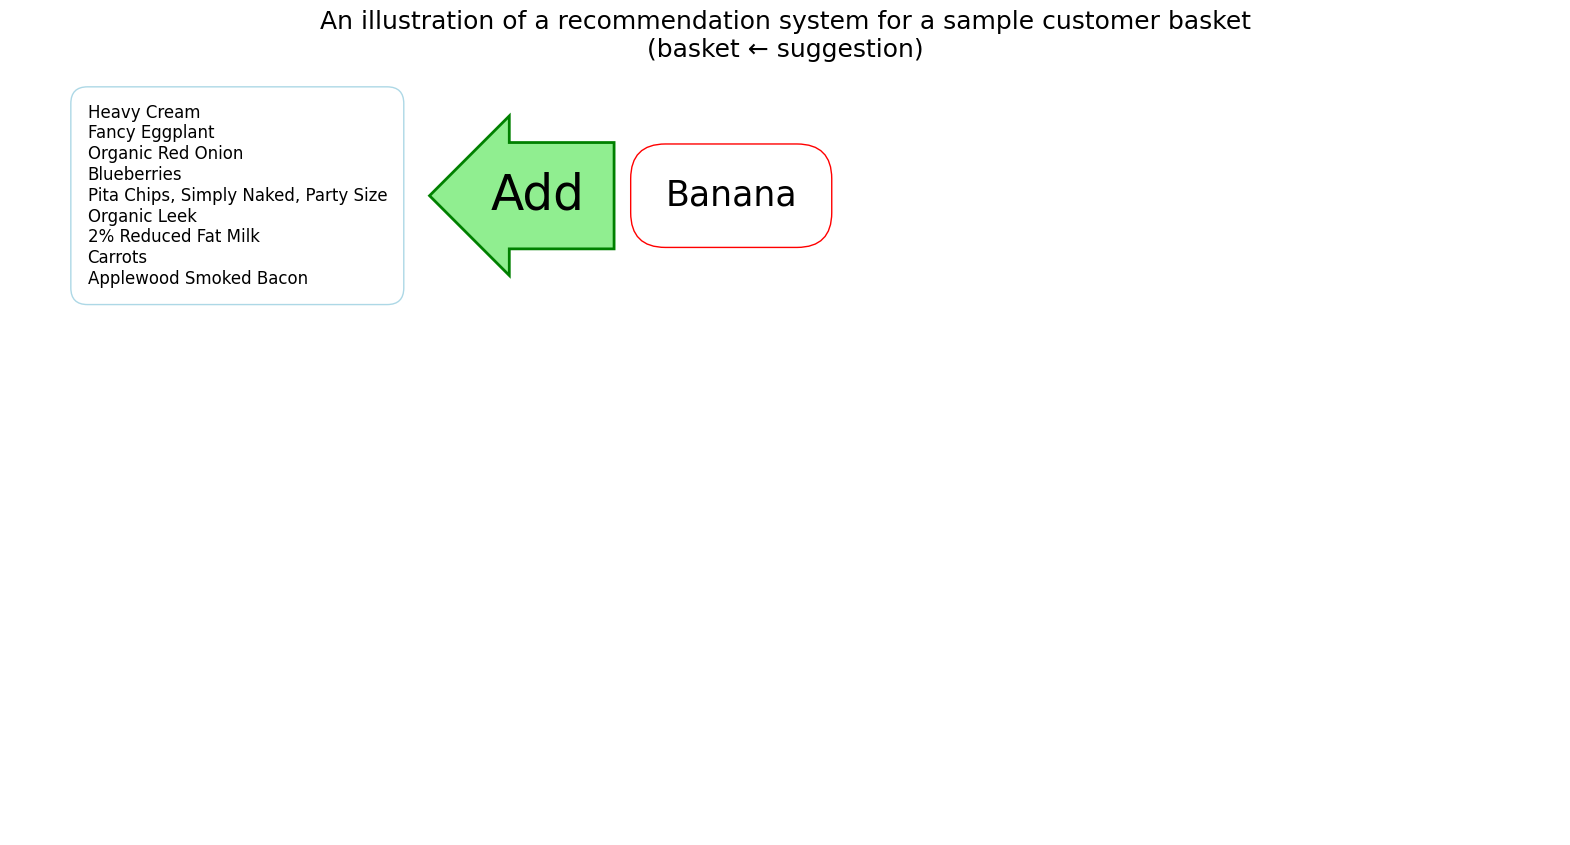

In [ ]:
sample_index = np.random.randint(len(non_empty_recs))
sample_basket = "\n".join(non_empty_recs.iloc[sample_index].loc["basket"])
sample_recommendation = "\n".join(non_empty_recs.iloc[sample_index].loc["recommendations"])
mba_diagram(sample_basket, sample_recommendation)